# YN Μέρος Β

## Β1

In [2]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
CSV_PATH = "alzheimers_disease_data.csv"  
TARGET = "Diagnosis"                      

df = pd.read_csv(CSV_PATH)

ID_LIKE_COLS = ["PatientID", "DoctorInCharge", "SubjectID", "MRI_ID", "ID"]
for col in ID_LIKE_COLS:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)


if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found. Update TARGET to your dataset.")
y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])

cat_cols = list(X.select_dtypes(include=["object", "category", "bool"]).columns)
num_cols = [c for c in X.columns if c not in cat_cols]

In [4]:
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)


In [5]:
numeric_pipe = Pipeline([('scaler', StandardScaler())])
cat_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ],
    remainder='drop'
)

# Fit on TRAIN only (no leakage), then transform both
X_train_tr = preprocessor.fit_transform(X_train_raw)
X_val_tr   = preprocessor.transform(X_val_raw)

X_train_tr = np.asarray(X_train_tr)
X_val_tr   = np.asarray(X_val_tr)

input_dim = X_train_tr.shape[1]

In [6]:
def build_best_model(input_dim):
    #A5 best was [I, I] with ReLU + SGD(lr=0.1, m=0.6)
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(input_dim, activation='relu'))  
    model.add(Dense(input_dim, activation='relu'))  
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=0.1, momentum=0.6),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_best_model(input_dim)

early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
_ = model.fit(
    X_train_tr, y_train,
    validation_data=(X_val_tr, y_val),
    epochs=200, verbose=0, callbacks=[early]
)

In [7]:
def build_column_groups(preprocessor, num_cols, cat_cols):
    try:
        names = preprocessor.get_feature_names_out()
    except AttributeError:
        raise RuntimeError(
            "preprocessor.get_feature_names_out() not available. "
        )
    column_groups = []
    feature_names = []

    def idx_where(pred):
        return np.array([i for i, nm in enumerate(names) if pred(nm)], dtype=int)

    for feat in num_cols:
        idx = idx_where(lambda nm, f=feat: nm == f"num__{f}")
        if idx.size == 0:
            idx = idx_where(lambda nm, f=feat: nm.startswith("num__") and nm.endswith(f))
        column_groups.append(idx)
        feature_names.append(feat)

    for feat in cat_cols:
        idx = idx_where(lambda nm, f=feat: nm.startswith(f"cat__{f}_") or nm == f"cat__{f}")
        column_groups.append(idx)  
        feature_names.append(feat)

    return column_groups, feature_names

In [8]:
#just some testing...ignore 
column_groups, original_feature_names = build_column_groups(preprocessor, num_cols, cat_cols)
n_features = len(column_groups)
print(f"Original features for GA (after A1 cleaning): {n_features}")

for name, grp in zip(original_feature_names, column_groups):
     print(f"{name}: transformed cols {grp}")

Original features for GA (after A1 cleaning): 32
Age: transformed cols [0]
Gender: transformed cols [1]
Ethnicity: transformed cols [2]
EducationLevel: transformed cols [3]
BMI: transformed cols [4]
Smoking: transformed cols [5]
AlcoholConsumption: transformed cols [6]
PhysicalActivity: transformed cols [7]
DietQuality: transformed cols [8]
SleepQuality: transformed cols [9]
FamilyHistoryAlzheimers: transformed cols [10]
CardiovascularDisease: transformed cols [11]
Diabetes: transformed cols [12]
Depression: transformed cols [13]
HeadInjury: transformed cols [14]
Hypertension: transformed cols [15]
SystolicBP: transformed cols [16]
DiastolicBP: transformed cols [17]
CholesterolTotal: transformed cols [18]
CholesterolLDL: transformed cols [19]
CholesterolHDL: transformed cols [20]
CholesterolTriglycerides: transformed cols [21]
MMSE: transformed cols [22]
FunctionalAssessment: transformed cols [23]
MemoryComplaints: transformed cols [24]
BehavioralProblems: transformed cols [25]
ADL: tr

### B1α, Β1β

In [9]:
rng = np.random.default_rng(42)

def create_chromosome(n_features):
    # binary vector with at least one '1'
    while True:
        ch = rng.integers(0, 2, size=n_features, dtype=int)
        if ch.sum() > 0:
            return ch

def initialize_population(pop_size, n_features):
    return np.vstack([create_chromosome(n_features) for _ in range(pop_size)])

### Β1γ

In [10]:
def apply_feature_mask(X_tr, chromosome, column_groups):

    X_masked = X_tr.copy()
    for gene, cols in zip(chromosome, column_groups):
        if gene == 0 and cols.size > 0:
            X_masked[:, cols] = 0.0
    return X_masked

def evaluate_chromosome(model, X_val_tr, y_val, chromosome, column_groups):
   
    if chromosome.sum() == 0:
        return np.inf, 0.0
    X_masked = apply_feature_mask(X_val_tr, chromosome, column_groups)
    y_prob = model.predict(X_masked, verbose=0).ravel()
    ce = log_loss(y_val, y_prob, labels=[0, 1])
    acc = accuracy_score(y_val, (y_prob >= 0.5).astype(int))
    return ce, acc

def chromosome_fitness(chromosome, lam=0.05):
    
    ce, acc = evaluate_chromosome(model, X_val_tr, y_val, chromosome, column_groups)
    k = int(chromosome.sum())
    n = len(chromosome)
    fitness = ce + lam * (k / n)
    return fitness, {"CE": ce, "Acc": acc, "k": k}

In [11]:
def tournament_select(pop, fits, k=3):
    
    m = len(pop)
    idx = rng.choice(m, size=k, replace=False)
    best = idx[0]
    best_fit = fits[idx[0]]
    for j in idx[1:]:
        if fits[j] < best_fit:
            best = j
            best_fit = fits[j]
    return pop[best].copy()

In [12]:
def one_point_crossover(p1, p2, pc=0.9):
  
    n = len(p1)
    if rng.random() > pc or n < 2:
        return p1.copy(), p2.copy()
    cut = rng.integers(1, n)  # cut in [1, n-1]
    c1 = np.concatenate([p1[:cut], p2[cut:]])
    c2 = np.concatenate([p2[:cut], p1[cut:]])
    # Keep at least one '1' per child
    if c1.sum() == 0:
        c1[rng.integers(0, n)] = 1
    if c2.sum() == 0:
        c2[rng.integers(0, n)] = 1
    return c1, c2

In [13]:
def bitflip_mutation(ch, pm=0.02):
   
    n = len(ch)
    mask = rng.random(n) < pm
    c = ch.copy()
    c[mask] ^= 1
    if c.sum() == 0:
        c[rng.integers(0, n)] = 1
    return c

In [16]:
def run_ga(
    pop_size=50,
    generations=40,
    pc=0.9,         # crossover probability
    pm=0.02,        # mutation probability
    tourn_k=3,      # tournament size
    elitism=2,      # # of top individuals copied unchanged
    lam=0.05,       # penalty strength for fitness
    verbose=True
):
    
    # Initialize population (chromosomes of length = number of original features)
    n_features = len(column_groups)
    pop = initialize_population(pop_size, n_features)

    # Evaluate initial population
    fits = np.empty(pop_size, dtype=float)
    metas = [None] * pop_size
    for i, ch in enumerate(pop):
        f, meta = chromosome_fitness(ch, lam=lam)
        fits[i] = f
        metas[i] = meta

    best_f_hist, best_meta_hist, best_ch_hist = [], [], []

    for gen in range(generations):
        # --- Elitism: keep E best
        elite_idx = np.argsort(fits)[:elitism]
        elites = pop[elite_idx].copy()
        elite_fits = fits[elite_idx].copy()
        elite_metas = [metas[i] for i in elite_idx]

        # --- Create offspring via selection + crossover + mutation
        new_pop = []
        while len(new_pop) < pop_size - elitism:
            p1 = tournament_select(pop, fits, k=tourn_k)
            p2 = tournament_select(pop, fits, k=tourn_k)
            c1, c2 = one_point_crossover(p1, p2, pc=pc)
            c1 = bitflip_mutation(c1, pm=pm)
            new_pop.append(c1)
            if len(new_pop) < pop_size - elitism:
                c2 = bitflip_mutation(c2, pm=pm)
                new_pop.append(c2)

        # --- Next generation: elites + offspring
        pop = np.vstack([elites] + new_pop)

        # --- Evaluate population
        fits = np.empty(pop_size, dtype=float)
        metas = [None] * pop_size
        for i, ch in enumerate(pop):
            f, meta = chromosome_fitness(ch, lam=lam)
            fits[i] = f
            metas[i] = meta

        # --- Track best of generation
        b = np.argmin(fits)
        best_f = fits[b]
        best_meta = metas[b]
        best_ch = pop[b].copy()

        best_f_hist.append(best_f)
        best_meta_hist.append(best_meta)
        best_ch_hist.append(best_ch)

        if verbose:
            ce_b, acc_b, k_b = best_meta['CE'], best_meta['Acc'], best_meta['k']
            print(f"Gen {gen+1:02d} | Best Fitness={best_f:.4f} | CE={ce_b:.4f} | Acc={acc_b:.4f} | k={k_b}")

    # --- Final best
    b = np.argmin(fits)
    return {
        "best_chromosome": pop[b].copy(),
        "best_fitness": float(fits[b]),
        "best_ce": float(metas[b]['CE']),
        "best_acc": float(metas[b]['Acc']),
        "best_k": int(metas[b]['k']),
        "fitness_history": best_f_hist,
        "meta_history": best_meta_hist,
        "chrom_history": best_ch_hist,
    }

In [17]:
result = run_ga(
    pop_size=50,
    generations=40,
    pc=0.9,
    pm=0.02,
    tourn_k=3,
    elitism=2,
    lam=0.05,
    verbose=True
)

print("\n=== GA Result ===")
print("Best Fitness:", round(result["best_fitness"], 4))
print("Best CE:", round(result["best_ce"], 4))
print("Best Acc:", round(result["best_acc"], 4))
print("Best k:", result["best_k"])

best_mask = result["best_chromosome"]

selected_idx = np.flatnonzero(best_mask)
best_features = [original_feature_names[i] for i in selected_idx]

print("Selected idx:", selected_idx.tolist())
print("Selected features:", best_features)

Gen 01 | Best Fitness=0.3806 | CE=0.3603 | Acc=0.8643 | k=13
Gen 02 | Best Fitness=0.3806 | CE=0.3603 | Acc=0.8643 | k=13
Gen 03 | Best Fitness=0.3753 | CE=0.3534 | Acc=0.8494 | k=14
Gen 04 | Best Fitness=0.3680 | CE=0.3461 | Acc=0.8699 | k=14
Gen 05 | Best Fitness=0.3680 | CE=0.3461 | Acc=0.8699 | k=14
Gen 06 | Best Fitness=0.3625 | CE=0.3422 | Acc=0.8662 | k=13
Gen 07 | Best Fitness=0.3591 | CE=0.3404 | Acc=0.8810 | k=12
Gen 08 | Best Fitness=0.3591 | CE=0.3404 | Acc=0.8810 | k=12
Gen 09 | Best Fitness=0.3513 | CE=0.3341 | Acc=0.8717 | k=11
Gen 10 | Best Fitness=0.3513 | CE=0.3341 | Acc=0.8717 | k=11
Gen 11 | Best Fitness=0.3513 | CE=0.3341 | Acc=0.8717 | k=11
Gen 12 | Best Fitness=0.3496 | CE=0.3340 | Acc=0.8699 | k=10
Gen 13 | Best Fitness=0.3496 | CE=0.3340 | Acc=0.8699 | k=10
Gen 14 | Best Fitness=0.3496 | CE=0.3340 | Acc=0.8699 | k=10
Gen 15 | Best Fitness=0.3496 | CE=0.3340 | Acc=0.8699 | k=10
Gen 16 | Best Fitness=0.3496 | CE=0.3340 | Acc=0.8699 | k=10
Gen 17 | Best Fitness=0.

## B3

In [18]:
def run_ga_b3(
    pop_size=50,
    pc=0.9,
    pm=0.02,
    tourn_k=3,
    elitism=2,
    lam=0.05,
    max_gens=1000,          # (iii)
    patience=30,            # (i)
    min_rel_improv=0.01,    # (ii)
    patience_rel=10,        
    verbose=False,
    rng_seed=None
):
    rng_local = np.random.default_rng(rng_seed)
    n_features = len(column_groups)
    pop = initialize_population(pop_size, n_features)

    # evaluate initial
    fits = np.empty(pop_size, dtype=float)
    metas = [None]*pop_size
    for i, ch in enumerate(pop):
        f, meta = chromosome_fitness(ch, lam=lam)
        fits[i] = f
        metas[i] = meta

    best_f_hist, best_meta_hist, best_ch_hist = [], [], []

    # init best trackers
    b = np.argmin(fits)
    best_f = fits[b]
    best_meta = metas[b]
    no_improve = 0
    low_improv_streak = 0

    for gen in range(1, max_gens+1):
        # record
        best_f_hist.append(best_f)
        best_meta_hist.append(best_meta)
        best_ch_hist.append(pop[b].copy())

        # (i) no improvement for `patience` gens
        if no_improve >= patience:
            if verbose: print(f"[Early stop] No improvement for {patience} generations at gen {gen-1}.")
            break
        # (ii) <1% relative improvement for `patience_rel` consecutive gens
        if low_improv_streak >= patience_rel:
            if verbose: print(f"[Early stop] <{min_rel_improv*100:.1f}% rel improvement for {patience_rel} gens at gen {gen-1}.")
            break

        # --- elitism ---
        elite_idx = np.argsort(fits)[:elitism]
        elites = pop[elite_idx]
        elite_fits = fits[elite_idx]
        elite_metas = [metas[i] for i in elite_idx]

        # --- offspring ---
        new_pop = []
        while len(new_pop) < pop_size - elitism:
            p1 = tournament_select(pop, fits, k=tourn_k)
            p2 = tournament_select(pop, fits, k=tourn_k)
            c1, c2 = one_point_crossover(p1, p2, pc=pc)
            c1 = bitflip_mutation(c1, pm=pm)
            new_pop.append(c1)
            if len(new_pop) < pop_size - elitism:
                c2 = bitflip_mutation(c2, pm=pm)
                new_pop.append(c2)

        pop = np.vstack([elites] + new_pop)

        # --- evaluate new pop ---
        fits = np.empty(pop_size, dtype=float)
        metas = [None]*pop_size
        for i, ch in enumerate(pop):
            f, meta = chromosome_fitness(ch, lam=lam)
            fits[i] = f
            metas[i] = meta

        # update best
        b_new = np.argmin(fits)
        new_best_f = fits[b_new]
        new_best_meta = metas[b_new]

        # improvement stats
        if new_best_f + 1e-12 < best_f:
            rel_improv = (best_f - new_best_f) / (abs(best_f) + 1e-12)
            no_improve = 0
            low_improv_streak = 0 if rel_improv >= min_rel_improv else (low_improv_streak + 1)
            best_f, best_meta, b = new_best_f, new_best_meta, b_new
        else:
            no_improve += 1
            low_improv_streak += 1

        if verbose:
            ce_b, acc_b, k_b = best_meta['CE'], best_meta['Acc'], best_meta['k']
            print(f"Gen {gen:03d} | Best Fitness={best_f:.4f} | CE={ce_b:.4f} | Acc={acc_b:.4f} | k={k_b}")

    gens_run = len(best_f_hist)
    return {
        "best_chromosome": pop[b].copy(),
        "best_fitness": float(best_f),
        "best_ce": float(best_meta['CE']),
        "best_acc": float(best_meta['Acc']),
        "best_k": int(best_meta['k']),
        "fitness_history": best_f_hist,   # list length = gens_run
        "meta_history": best_meta_hist,   # list of dicts
        "chrom_history": best_ch_hist,
        "generations_run": gens_run
    }



In [19]:
def run_single_combo(
    pop_size, pc, pm,
    repeats=5,
    lam=0.05,
    max_gens=600,
    patience=20,
    min_rel_improv=0.01,
    patience_rel=8,
    verbose=True,
    base_seed=100
):
  
    # local mean-curve aggregator
    def mean_curve(histories):
        if not histories:
            return np.array([])
        L = max(len(h) for h in histories)
        arr = np.zeros((len(histories), L), dtype=float)
        for i, h in enumerate(histories):
            arr[i, :len(h)] = h
            if len(h) < L:
                arr[i, len(h):] = h[-1]
        return np.mean(arr, axis=0)

    fitnesses, ces, accs, ks, gens = [], [], [], [], []
    curves = []

    start = time.time()
    for r in range(repeats):
        out = run_ga_b3(
            pop_size=pop_size, pc=pc, pm=pm,
            tourn_k=3, elitism=2, lam=lam,
            max_gens=max_gens,
            patience=patience,
            min_rel_improv=min_rel_improv,
            patience_rel=patience_rel,
            verbose=False,
            rng_seed=base_seed + r
        )
        fitnesses.append(out["best_fitness"])
        ces.append(out["best_ce"])
        accs.append(out["best_acc"])
        ks.append(out["best_k"])
        gens.append(out["generations_run"])
        curves.append(out["fitness_history"])

        if verbose:
            print(f"[{r+1}/{repeats}] pop={pop_size}, pc={pc}, pm={pm} "
                  f"→ Fit={out['best_fitness']:.4f}, CE={out['best_ce']:.4f}, "
                  f"Acc={out['best_acc']:.4f}, k={out['best_k']}, gens={out['generations_run']}")

    elapsed = time.time() - start
    mcurve = mean_curve(curves)

    df_row = pd.DataFrame([{
        "pop_size": pop_size, "pc": pc, "pm": pm,
        "fitness_mean": float(np.mean(fitnesses)),
        "fitness_std":  float(np.std(fitnesses)),
        "CE_mean": float(np.mean(ces)),
        "CE_std":  float(np.std(ces)),
        "Acc_mean": float(np.mean(accs)),
        "Acc_std":  float(np.std(accs)),
        "k_mean": float(np.mean(ks)),
        "k_std":  float(np.std(ks)),
        "gens_mean": float(np.mean(gens)),
        "gens_std":  float(np.std(gens)),
        "runs": repeats,
        "time_sec": round(elapsed, 2)
    }])

    return df_row, mcurve

[1/10] pop=20, pc=0.6, pm=0.0 → Fit=0.4178, CE=0.3944, Acc=0.8513, k=15, gens=7
[2/10] pop=20, pc=0.6, pm=0.0 → Fit=0.4646, CE=0.4396, Acc=0.8290, k=16, gens=6
[3/10] pop=20, pc=0.6, pm=0.0 → Fit=0.4072, CE=0.3838, Acc=0.8550, k=15, gens=7
[4/10] pop=20, pc=0.6, pm=0.0 → Fit=0.4266, CE=0.4016, Acc=0.8346, k=16, gens=6
[5/10] pop=20, pc=0.6, pm=0.0 → Fit=0.4121, CE=0.3840, Acc=0.8476, k=18, gens=7
[6/10] pop=20, pc=0.6, pm=0.0 → Fit=0.4191, CE=0.3926, Acc=0.8457, k=17, gens=10
[7/10] pop=20, pc=0.6, pm=0.0 → Fit=0.4620, CE=0.4385, Acc=0.8364, k=15, gens=9
[8/10] pop=20, pc=0.6, pm=0.0 → Fit=0.4756, CE=0.4475, Acc=0.8290, k=18, gens=9
[9/10] pop=20, pc=0.6, pm=0.0 → Fit=0.4633, CE=0.4383, Acc=0.8216, k=16, gens=13
[10/10] pop=20, pc=0.6, pm=0.0 → Fit=0.4183, CE=0.3886, Acc=0.8532, k=19, gens=9
   pop_size   pc   pm  fitness_mean  fitness_std   CE_mean    CE_std  \
0        20  0.6  0.0      0.436666     0.024927  0.410885  0.025148   

   Acc_mean   Acc_std  k_mean     k_std  gens_mean  

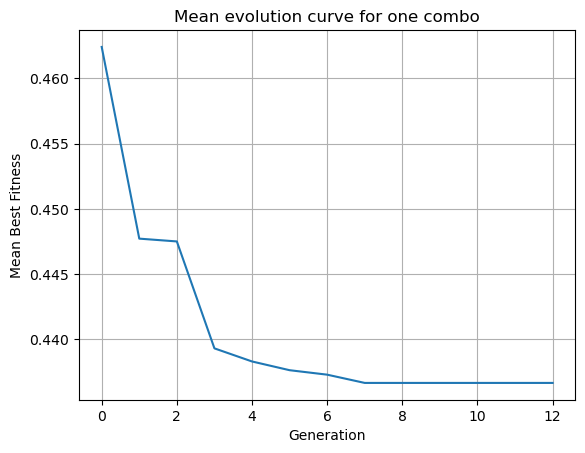

In [22]:
# 1st combo
df_one, curve_one = run_single_combo(
    pop_size=20,
    pc=0.6,
    pm=0.00,
    repeats=10,        
    lam=0.05,
    max_gens=300,     
    patience=15,
    min_rel_improv=0.01,
    patience_rel=5,
    verbose=True
)
print(df_one)

plt.figure()
plt.plot(curve_one)
plt.xlabel("Generation")
plt.ylabel("Mean Best Fitness")
plt.title("Mean evolution curve for one combo")
plt.grid(True)
plt.show()

[1/10] pop=20, pc=0.6, pm=0.01 → Fit=0.3962, CE=0.3775, Acc=0.8494, k=12, gens=14
[2/10] pop=20, pc=0.6, pm=0.01 → Fit=0.4251, CE=0.3970, Acc=0.8327, k=18, gens=6
[3/10] pop=20, pc=0.6, pm=0.01 → Fit=0.4690, CE=0.4456, Acc=0.8160, k=15, gens=13
[4/10] pop=20, pc=0.6, pm=0.01 → Fit=0.4105, CE=0.3886, Acc=0.8494, k=14, gens=9
[5/10] pop=20, pc=0.6, pm=0.01 → Fit=0.4593, CE=0.4343, Acc=0.8401, k=16, gens=7
[6/10] pop=20, pc=0.6, pm=0.01 → Fit=0.3907, CE=0.3735, Acc=0.8569, k=11, gens=15
[7/10] pop=20, pc=0.6, pm=0.01 → Fit=0.4652, CE=0.4386, Acc=0.8271, k=17, gens=6
[8/10] pop=20, pc=0.6, pm=0.01 → Fit=0.3927, CE=0.3739, Acc=0.8439, k=12, gens=15
[9/10] pop=20, pc=0.6, pm=0.01 → Fit=0.4010, CE=0.3760, Acc=0.8439, k=16, gens=13
[10/10] pop=20, pc=0.6, pm=0.01 → Fit=0.4114, CE=0.3879, Acc=0.8401, k=15, gens=12
   pop_size   pc    pm  fitness_mean  fitness_std   CE_mean    CE_std  \
0        20  0.6  0.01      0.422096      0.02944  0.399283  0.027368   

   Acc_mean  Acc_std  k_mean  k_std 

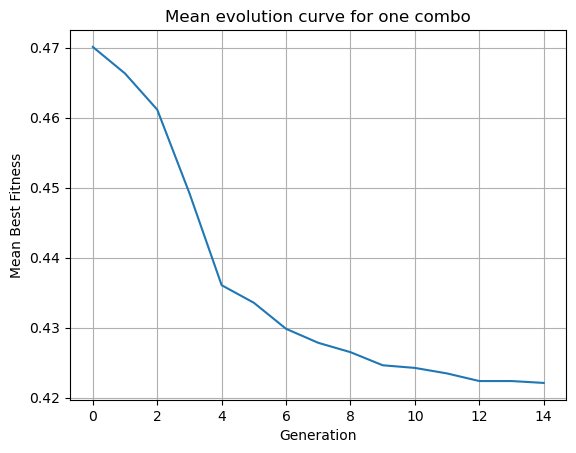

In [23]:
# 2nd combo
df_one, curve_one = run_single_combo(
    pop_size=20,
    pc=0.6,
    pm=0.01,
    repeats=10,        
    lam=0.05,
    max_gens=300,     
    patience=15,
    min_rel_improv=0.01,
    patience_rel=5,
    verbose=True
)
print(df_one)

plt.figure()
plt.plot(curve_one)
plt.xlabel("Generation")
plt.ylabel("Mean Best Fitness")
plt.title("Mean evolution curve for one combo")
plt.grid(True)
plt.show()

[1/10] pop=20, pc=0.6, pm=0.1 → Fit=0.3975, CE=0.3788, Acc=0.8587, k=12, gens=8
[2/10] pop=20, pc=0.6, pm=0.1 → Fit=0.3879, CE=0.3723, Acc=0.8439, k=10, gens=22
[3/10] pop=20, pc=0.6, pm=0.1 → Fit=0.3946, CE=0.3774, Acc=0.8420, k=11, gens=12
[4/10] pop=20, pc=0.6, pm=0.1 → Fit=0.4019, CE=0.3769, Acc=0.8532, k=16, gens=11
[5/10] pop=20, pc=0.6, pm=0.1 → Fit=0.3922, CE=0.3735, Acc=0.8476, k=12, gens=10
[6/10] pop=20, pc=0.6, pm=0.1 → Fit=0.3915, CE=0.3743, Acc=0.8532, k=11, gens=16
[7/10] pop=20, pc=0.6, pm=0.1 → Fit=0.3918, CE=0.3731, Acc=0.8513, k=12, gens=10
[8/10] pop=20, pc=0.6, pm=0.1 → Fit=0.3943, CE=0.3724, Acc=0.8476, k=14, gens=17
[9/10] pop=20, pc=0.6, pm=0.1 → Fit=0.3978, CE=0.3790, Acc=0.8513, k=12, gens=10
[10/10] pop=20, pc=0.6, pm=0.1 → Fit=0.3942, CE=0.3708, Acc=0.8476, k=15, gens=14
   pop_size   pc   pm  fitness_mean  fitness_std   CE_mean    CE_std  \
0        20  0.6  0.1      0.394376     0.003744  0.374844  0.002798   

   Acc_mean   Acc_std  k_mean     k_std  gens

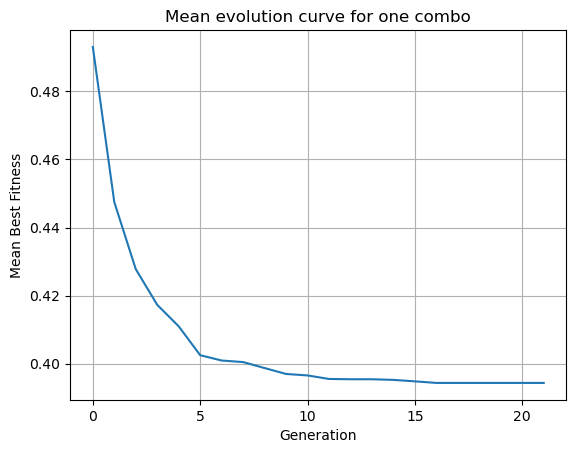

In [24]:
# 3rd combo
df_one, curve_one = run_single_combo(
    pop_size=20,
    pc=0.6,
    pm=0.10,
    repeats=10,        
    lam=0.05,
    max_gens=300,     
    patience=15,
    min_rel_improv=0.01,
    patience_rel=5,
    verbose=True
)
print(df_one)

plt.figure()
plt.plot(curve_one)
plt.xlabel("Generation")
plt.ylabel("Mean Best Fitness")
plt.title("Mean evolution curve for one combo")
plt.grid(True)
plt.show()

[1/10] pop=20, pc=0.9, pm=0.01 → Fit=0.3996, CE=0.3839, Acc=0.8401, k=10, gens=9
[2/10] pop=20, pc=0.9, pm=0.01 → Fit=0.3893, CE=0.3722, Acc=0.8457, k=11, gens=17
[3/10] pop=20, pc=0.9, pm=0.01 → Fit=0.3965, CE=0.3746, Acc=0.8569, k=14, gens=7
[4/10] pop=20, pc=0.9, pm=0.01 → Fit=0.4001, CE=0.3845, Acc=0.8569, k=10, gens=14
[5/10] pop=20, pc=0.9, pm=0.01 → Fit=0.3910, CE=0.3707, Acc=0.8550, k=13, gens=18
[6/10] pop=20, pc=0.9, pm=0.01 → Fit=0.4034, CE=0.3784, Acc=0.8550, k=16, gens=12
[7/10] pop=20, pc=0.9, pm=0.01 → Fit=0.3978, CE=0.3743, Acc=0.8476, k=15, gens=11
[8/10] pop=20, pc=0.9, pm=0.01 → Fit=0.4044, CE=0.3779, Acc=0.8476, k=17, gens=11
[9/10] pop=20, pc=0.9, pm=0.01 → Fit=0.4047, CE=0.3797, Acc=0.8476, k=16, gens=12
[10/10] pop=20, pc=0.9, pm=0.01 → Fit=0.4058, CE=0.3855, Acc=0.8346, k=13, gens=9
   pop_size   pc    pm  fitness_mean  fitness_std   CE_mean    CE_std  \
0        20  0.9  0.01      0.399257     0.005421  0.378163  0.004986   

   Acc_mean   Acc_std  k_mean     k

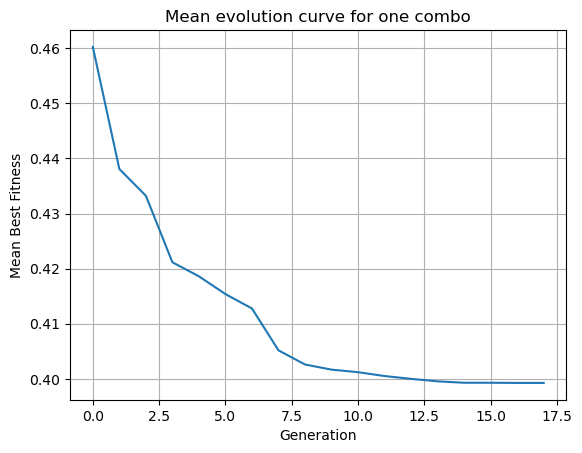

In [25]:
# 4th combo
df_one, curve_one = run_single_combo(
    pop_size=20,
    pc=0.9,
    pm=0.01,
    repeats=10,        
    lam=0.05,
    max_gens=300,     
    patience=15,
    min_rel_improv=0.01,
    patience_rel=5,
    verbose=True
)
print(df_one)

plt.figure()
plt.plot(curve_one)
plt.xlabel("Generation")
plt.ylabel("Mean Best Fitness")
plt.title("Mean evolution curve for one combo")
plt.grid(True)
plt.show()

[1/10] pop=20, pc=0.1, pm=0.01 → Fit=0.3994, CE=0.3791, Acc=0.8532, k=13, gens=20
[2/10] pop=20, pc=0.1, pm=0.01 → Fit=0.4141, CE=0.3860, Acc=0.8364, k=18, gens=10
[3/10] pop=20, pc=0.1, pm=0.01 → Fit=0.3928, CE=0.3741, Acc=0.8494, k=12, gens=21
[4/10] pop=20, pc=0.1, pm=0.01 → Fit=0.4046, CE=0.3827, Acc=0.8532, k=14, gens=14
[5/10] pop=20, pc=0.1, pm=0.01 → Fit=0.4049, CE=0.3845, Acc=0.8439, k=13, gens=18
[6/10] pop=20, pc=0.1, pm=0.01 → Fit=0.4603, CE=0.4431, Acc=0.8048, k=11, gens=11
[7/10] pop=20, pc=0.1, pm=0.01 → Fit=0.4242, CE=0.3929, Acc=0.8401, k=20, gens=8
[8/10] pop=20, pc=0.1, pm=0.01 → Fit=0.4239, CE=0.3927, Acc=0.8290, k=20, gens=10
[9/10] pop=20, pc=0.1, pm=0.01 → Fit=0.3998, CE=0.3748, Acc=0.8457, k=16, gens=14
[10/10] pop=20, pc=0.1, pm=0.01 → Fit=0.3927, CE=0.3708, Acc=0.8420, k=14, gens=13
   pop_size   pc    pm  fitness_mean  fitness_std   CE_mean    CE_std  \
0        20  0.1  0.01      0.411682     0.019435  0.388088  0.019662   

   Acc_mean   Acc_std  k_mean    

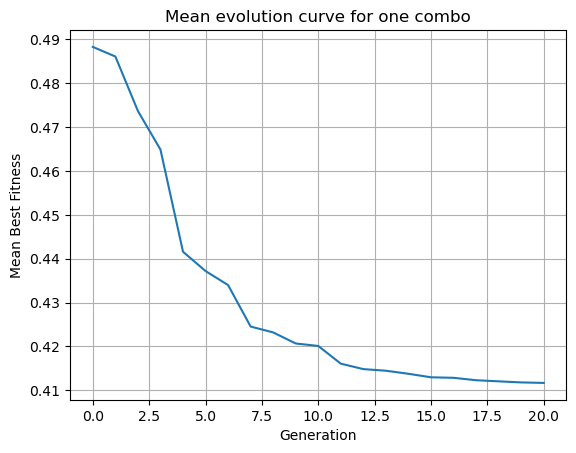

In [26]:
# 5th combo
df_one, curve_one = run_single_combo(
    pop_size=20,
    pc=0.1,
    pm=0.01,
    repeats=10,        
    lam=0.05,
    max_gens=300,     
    patience=15,
    min_rel_improv=0.01,
    patience_rel=5,
    verbose=True
)
print(df_one)

plt.figure()
plt.plot(curve_one)
plt.xlabel("Generation")
plt.ylabel("Mean Best Fitness")
plt.title("Mean evolution curve for one combo")
plt.grid(True)
plt.show()

[1/10] pop=200, pc=0.6, pm=0.0 → Fit=0.3868, CE=0.3696, Acc=0.8606, k=11, gens=11
[2/10] pop=200, pc=0.6, pm=0.0 → Fit=0.3879, CE=0.3723, Acc=0.8532, k=10, gens=11
[3/10] pop=200, pc=0.6, pm=0.0 → Fit=0.3895, CE=0.3707, Acc=0.8457, k=12, gens=9
[4/10] pop=200, pc=0.6, pm=0.0 → Fit=0.3875, CE=0.3719, Acc=0.8587, k=10, gens=10
[5/10] pop=200, pc=0.6, pm=0.0 → Fit=0.3962, CE=0.3727, Acc=0.8457, k=15, gens=7
[6/10] pop=200, pc=0.6, pm=0.0 → Fit=0.3922, CE=0.3766, Acc=0.8606, k=10, gens=10
[7/10] pop=200, pc=0.6, pm=0.0 → Fit=0.3866, CE=0.3679, Acc=0.8587, k=12, gens=12
[8/10] pop=200, pc=0.6, pm=0.0 → Fit=0.3879, CE=0.3707, Acc=0.8532, k=11, gens=9
[9/10] pop=200, pc=0.6, pm=0.0 → Fit=0.3865, CE=0.3708, Acc=0.8587, k=10, gens=7
[10/10] pop=200, pc=0.6, pm=0.0 → Fit=0.3846, CE=0.3721, Acc=0.8513, k=8, gens=12
   pop_size   pc   pm  fitness_mean  fitness_std   CE_mean    CE_std  \
0       200  0.6  0.0      0.388556     0.003177  0.371525  0.002161   

   Acc_mean   Acc_std  k_mean    k_std 

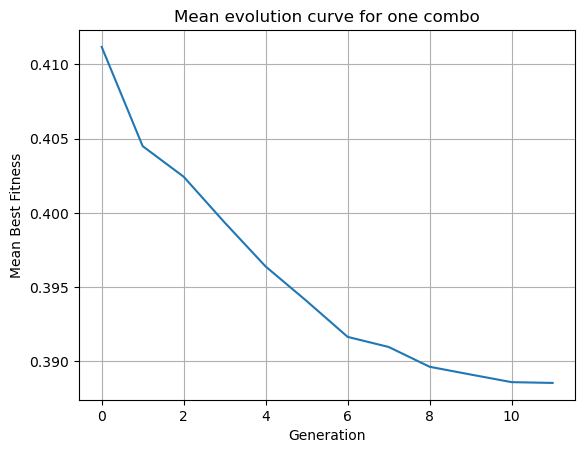

In [27]:
# 6th combo
df_one, curve_one = run_single_combo(
    pop_size=200,
    pc=0.6,
    pm=0.00,
    repeats=10,        
    lam=0.05,
    max_gens=300,     
    patience=15,
    min_rel_improv=0.01,
    patience_rel=5,
    verbose=True
)
print(df_one)

plt.figure()
plt.plot(curve_one)
plt.xlabel("Generation")
plt.ylabel("Mean Best Fitness")
plt.title("Mean evolution curve for one combo")
plt.grid(True)
plt.show()

[1/10] pop=200, pc=0.6, pm=0.01 → Fit=0.3853, CE=0.3681, Acc=0.8532, k=11, gens=11
[2/10] pop=200, pc=0.6, pm=0.01 → Fit=0.3909, CE=0.3706, Acc=0.8625, k=13, gens=9
[3/10] pop=200, pc=0.6, pm=0.01 → Fit=0.3830, CE=0.3673, Acc=0.8569, k=10, gens=15
[4/10] pop=200, pc=0.6, pm=0.01 → Fit=0.3833, CE=0.3645, Acc=0.8625, k=12, gens=17
[5/10] pop=200, pc=0.6, pm=0.01 → Fit=0.4021, CE=0.3771, Acc=0.8476, k=16, gens=6
[6/10] pop=200, pc=0.6, pm=0.01 → Fit=0.3867, CE=0.3695, Acc=0.8494, k=11, gens=11
[7/10] pop=200, pc=0.6, pm=0.01 → Fit=0.3869, CE=0.3728, Acc=0.8476, k=9, gens=12
[8/10] pop=200, pc=0.6, pm=0.01 → Fit=0.3830, CE=0.3673, Acc=0.8569, k=10, gens=15
[9/10] pop=200, pc=0.6, pm=0.01 → Fit=0.3858, CE=0.3718, Acc=0.8494, k=9, gens=12
[10/10] pop=200, pc=0.6, pm=0.01 → Fit=0.3935, CE=0.3716, Acc=0.8457, k=14, gens=8
   pop_size   pc    pm  fitness_mean  fitness_std   CE_mean    CE_std  \
0       200  0.6  0.01      0.388041     0.005704  0.370072  0.003354   

   Acc_mean   Acc_std  k_me

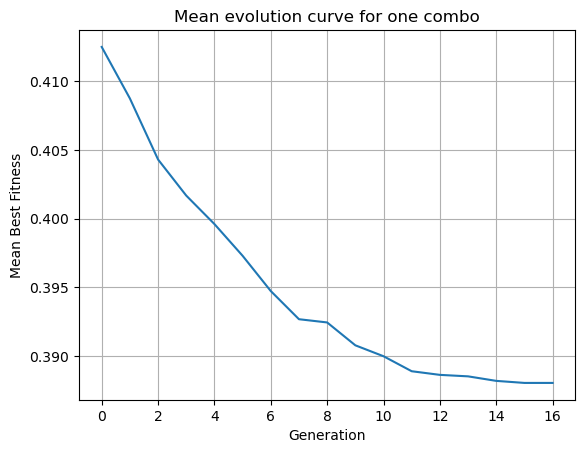

In [28]:
# 7th combo
df_one, curve_one = run_single_combo(
    pop_size=200,
    pc=0.6,
    pm=0.01,
    repeats=10,        
    lam=0.05,
    max_gens=300,     
    patience=15,
    min_rel_improv=0.01,
    patience_rel=5,
    verbose=True
)
print(df_one)

plt.figure()
plt.plot(curve_one)
plt.xlabel("Generation")
plt.ylabel("Mean Best Fitness")
plt.title("Mean evolution curve for one combo")
plt.grid(True)
plt.show()

[1/10] pop=200, pc=0.6, pm=0.1 → Fit=0.3569, CE=0.3382, Acc=0.8736, k=12, gens=11
[2/10] pop=200, pc=0.6, pm=0.1 → Fit=0.3629, CE=0.3411, Acc=0.8625, k=14, gens=8
[3/10] pop=200, pc=0.6, pm=0.1 → Fit=0.3525, CE=0.3353, Acc=0.8792, k=11, gens=17
[4/10] pop=200, pc=0.6, pm=0.1 → Fit=0.3551, CE=0.3332, Acc=0.8717, k=14, gens=13
[5/10] pop=200, pc=0.6, pm=0.1 → Fit=0.3536, CE=0.3380, Acc=0.8625, k=10, gens=14
[6/10] pop=200, pc=0.6, pm=0.1 → Fit=0.3629, CE=0.3379, Acc=0.8736, k=16, gens=9
[7/10] pop=200, pc=0.6, pm=0.1 → Fit=0.3520, CE=0.3348, Acc=0.8755, k=11, gens=20
[8/10] pop=200, pc=0.6, pm=0.1 → Fit=0.3599, CE=0.3364, Acc=0.8680, k=15, gens=10
[9/10] pop=200, pc=0.6, pm=0.1 → Fit=0.3607, CE=0.3404, Acc=0.8662, k=13, gens=12
[10/10] pop=200, pc=0.6, pm=0.1 → Fit=0.3597, CE=0.3347, Acc=0.8717, k=16, gens=10
   pop_size   pc   pm  fitness_mean  fitness_std   CE_mean    CE_std  \
0       200  0.6  0.1      0.357629     0.003939  0.337004  0.002412   

   Acc_mean   Acc_std  k_mean     k_

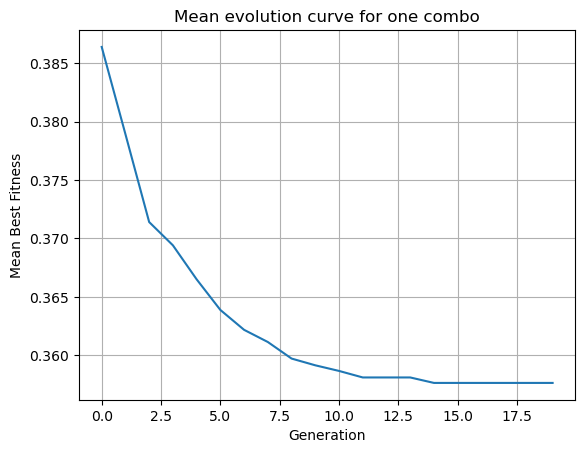

In [20]:
# 8th combo
df_one, curve_one = run_single_combo(
    pop_size=200,
    pc=0.6,
    pm=0.10,
    repeats=10,        
    lam=0.05,
    max_gens=300,     
    patience=15,
    min_rel_improv=0.01,
    patience_rel=5,
    verbose=True
)
print(df_one)

plt.figure()
plt.plot(curve_one)
plt.xlabel("Generation")
plt.ylabel("Mean Best Fitness")
plt.title("Mean evolution curve for one combo")
plt.grid(True)
plt.show()

[1/10] pop=200, pc=0.9, pm=0.01 → Fit=0.3483, CE=0.3296, Acc=0.8662, k=12, gens=17
[2/10] pop=200, pc=0.9, pm=0.01 → Fit=0.3483, CE=0.3296, Acc=0.8662, k=12, gens=18
[3/10] pop=200, pc=0.9, pm=0.01 → Fit=0.3485, CE=0.3328, Acc=0.8773, k=10, gens=15
[4/10] pop=200, pc=0.9, pm=0.01 → Fit=0.3483, CE=0.3296, Acc=0.8792, k=12, gens=15
[5/10] pop=200, pc=0.9, pm=0.01 → Fit=0.3495, CE=0.3354, Acc=0.8662, k=9, gens=12
[6/10] pop=200, pc=0.9, pm=0.01 → Fit=0.3493, CE=0.3290, Acc=0.8662, k=13, gens=16
[7/10] pop=200, pc=0.9, pm=0.01 → Fit=0.3495, CE=0.3354, Acc=0.8662, k=9, gens=11
[8/10] pop=200, pc=0.9, pm=0.01 → Fit=0.3485, CE=0.3328, Acc=0.8773, k=10, gens=13
[9/10] pop=200, pc=0.9, pm=0.01 → Fit=0.3527, CE=0.3293, Acc=0.8755, k=15, gens=12
[10/10] pop=200, pc=0.9, pm=0.01 → Fit=0.3471, CE=0.3253, Acc=0.8848, k=14, gens=15
   pop_size   pc    pm  fitness_mean  fitness_std   CE_mean    CE_std  \
0       200  0.9  0.01      0.349006     0.001414  0.330881  0.003029   

   Acc_mean   Acc_std  k

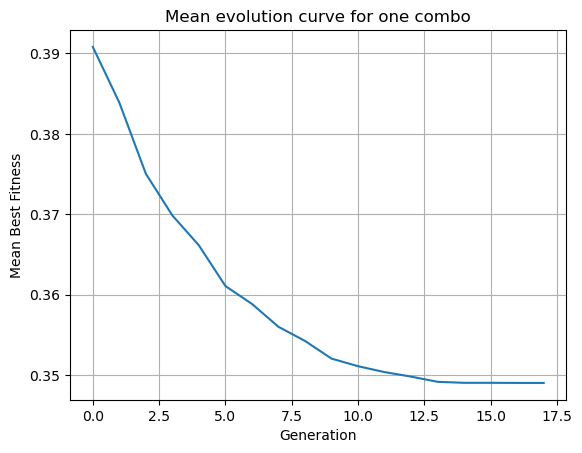

In [21]:
# 9th combo
df_one, curve_one = run_single_combo(
    pop_size=200,
    pc=0.9,
    pm=0.01,
    repeats=10,        
    lam=0.05,
    max_gens=300,     
    patience=15,
    min_rel_improv=0.01,
    patience_rel=5,
    verbose=True
)
print(df_one)

plt.figure()
plt.plot(curve_one)
plt.xlabel("Generation")
plt.ylabel("Mean Best Fitness")
plt.title("Mean evolution curve for one combo")
plt.grid(True)
plt.show()

[1/10] pop=200, pc=0.1, pm=0.01 → Fit=0.3571, CE=0.3368, Acc=0.8643, k=13, gens=13
[2/10] pop=200, pc=0.1, pm=0.01 → Fit=0.3557, CE=0.3385, Acc=0.8717, k=11, gens=14
[3/10] pop=200, pc=0.1, pm=0.01 → Fit=0.3471, CE=0.3253, Acc=0.8848, k=14, gens=17
[4/10] pop=200, pc=0.1, pm=0.01 → Fit=0.3569, CE=0.3319, Acc=0.8755, k=16, gens=13
[5/10] pop=200, pc=0.1, pm=0.01 → Fit=0.3569, CE=0.3366, Acc=0.8625, k=13, gens=17
[6/10] pop=200, pc=0.1, pm=0.01 → Fit=0.3667, CE=0.3386, Acc=0.8680, k=18, gens=9
[7/10] pop=200, pc=0.1, pm=0.01 → Fit=0.3485, CE=0.3328, Acc=0.8773, k=10, gens=17
[8/10] pop=200, pc=0.1, pm=0.01 → Fit=0.3535, CE=0.3332, Acc=0.8773, k=13, gens=15
[9/10] pop=200, pc=0.1, pm=0.01 → Fit=0.3487, CE=0.3315, Acc=0.8755, k=11, gens=23
[10/10] pop=200, pc=0.1, pm=0.01 → Fit=0.3518, CE=0.3314, Acc=0.8810, k=13, gens=19
   pop_size   pc    pm  fitness_mean  fitness_std   CE_mean    CE_std  \
0       200  0.1  0.01      0.354283     0.005495  0.333658  0.003876   

   Acc_mean   Acc_std  

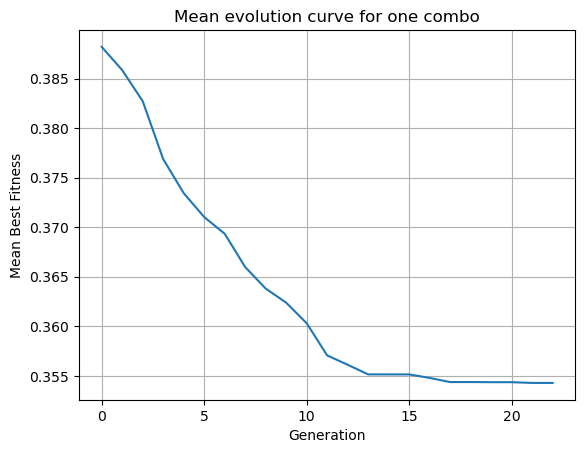

In [22]:
# 10th combo
df_one, curve_one = run_single_combo(
    pop_size=200,
    pc=0.1,
    pm=0.01,
    repeats=10,        
    lam=0.05,
    max_gens=300,     
    patience=15,
    min_rel_improv=0.01,
    patience_rel=5,
    verbose=True
)
print(df_one)

plt.figure()
plt.plot(curve_one)
plt.xlabel("Generation")
plt.ylabel("Mean Best Fitness")
plt.title("Mean evolution curve for one combo")
plt.grid(True)
plt.show()